<a href="https://colab.research.google.com/github/PariaNajafi/Deep-Learning-BootCamp/blob/main/OnAcademy_DeepLearning_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sentiment Classification(analysis) Using RNNs

In [1]:
#https://ai.stanford.edu/~amaas/sentiment/

In [2]:
!pip install datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 2.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-c

In [3]:
#torchtext,datasets

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt_tab') # for tokenize
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from torch.utils.data import DataLoader,TensorDataset
from torch.nn.utils.rnn import pad_sequence

print("PyTorch Version:", torch.__version__)

PyTorch Version: 2.6.0+cu124


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [5]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

Using Device: cpu


Classification, labels:0,1 , comment says the film is good or bad

##Load and Preprocess IMDB Dataset

In [6]:
dataset = load_dataset("imdb")
train_data = dataset["train"]
test_data = dataset["test"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

We need to convert word and sentence data into numerical equivalents.
hello : 0,
the : 5,
, : 4

In [7]:
def build_vocab(texts, max_vocab_size=10000):
    all_tokens = []
    for text in texts:
        tokens = word_tokenize(text.lower())
        all_tokens.extend(tokens)
    token_counts = Counter(all_tokens)
    # Sort tokens by frequency in descending order by making a dictionary
    vocab = {'<pad>' : 0, '<unk>' : 1}
    vocab.update({token : ind + 2 for ind, (token, _) in enumerate(token_counts.most_common(max_vocab_size - 2))})
    return vocab


In [8]:
vocab = build_vocab(train_data["text"])
#how manay words exicts in vocabulary
print(f"Vocabulary Size: {len(vocab)}")
#now we have made numeral ecuivalants of words, now we have a dictionary, any word out of this dictionary equivalants with unknown

Vocabulary Size: 10000


In [9]:
#comment classifies the film in good or bad classes in first 100 words.
def text_to_indices(text, vocab,max_len=100):
    tokens = word_tokenize(text.lower())[:max_len]
    indices = [vocab.get(token, vocab['<unk>']) for token in tokens]

    return indices


In [10]:
def process_data(data,vocab, max_len=100):
  texts = [text_to_indices(text, vocab, max_len) for text in data['text']]
  labels = [label for label in data['label']]
  3# Pad sequences
  padded_texts = [torch.tensor(text, dtype=torch.long) for text in texts]
  padded_texts = pad_sequence(padded_texts, batch_first=True, padding_value=0)
  labels = torch.tensor(labels, dtype=torch.float32)

  return padded_texts, labels

In [11]:
train_texts, train_labels = process_data(train_data, vocab)
test_texts, test_labels = process_data(test_data, vocab)
train_dataset = TensorDataset(train_texts, train_labels)
test_dataset = TensorDataset(test_texts, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

####test

In [12]:
train_data[0]['text']
#train data is a dictionary with 2 elements

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

In [14]:

all_tokens = []
for text in train_data["text"]:
        tokens = word_tokenize(text.lower())
        all_tokens.extend(tokens)
token_counts = Counter(all_tokens)


In [15]:
token_counts.most_common(5)

[('the', 334840), (',', 275887), ('.', 234798), ('and', 163477), ('a', 162292)]

In [16]:
a= [torch.tensor([5, 6, 7]), torch.tensor([5, 6, 7, 10, 12, 15])]
pad_sequence(a, padding_value=0)

tensor([[ 5,  5],
        [ 6,  6],
        [ 7,  7],
        [ 0, 10],
        [ 0, 12],
        [ 0, 15]])

#Build Model

In [20]:
class SentimentLSTM(nn.Module):
  def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
    super(SentimentLSTM, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embed_dim,padding_idx=0)
    self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True) #output = hidden_dim
    self.fc = nn.Linear(hidden_dim, output_dim)
    self.sigmoid = nn.Sigmoid()
  def forward(self, text):
    embedded = self.embedding(text) #[batch, seq_len, embed_dim]
    _, (hidden, _) = self.lstm(embedded) #hidden: [1, batch, hidden_dim] ,_ : all LSTMs outputs,  the last blocks output: (hidden, _)
    hidden = hidden.squeeze(0) #[batch, hidden_dim]
    output = self.fc(hidden) # [batch, output_dim]
    return self.sigmoid(output)
    #2 class classification passes to sigmoid activation, >0.5 : 1 , <0.5 : 0
    # we dont pass the lenght to RNNs, it handles it itself

# Model parameters
VOCAB_SIZE = len(vocab)
EMBED_DIM = 50
HIDDEN_DIM = 128
OUTPUT_DIM = 1

model = SentimentLSTM(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM)
model.to(device)
print(model)

SentimentLSTM(
  (embedding): Embedding(10000, 50, padding_idx=0)
  (lstm): LSTM(50, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


####test

In [24]:
aa = nn.embedding = nn.Embedding(10000,150 ,padding_idx=0)
#(vocab_size,embed_dim )
# max value of numbers = 1000
# mbed_dim is the length of the array
# padding_ind=0  dont do back propagation or deviation for this part of data, dont update 0 values they are padding and must have no effect
# in one hot encoding value was specific but in embedding it is not specific and it specifies in the process, its not a discrete array full of 0 and 1, they are between 2 number
for i in train_texts:
  a = aa(i)
  print(a)
  print(a.shape)
  break

#[100,150] sequence size(tedad vajegan jomle), each word equevalents an array with 150 elements.150 depends on systems Computational Limitation,
#optimized size depends on size of the dictionary whitch here is 1000

tensor([[-0.4453, -0.6315,  0.4478,  ..., -0.1210,  0.3574,  1.0634],
        [ 1.1225,  0.0562,  1.0436,  ..., -0.1933,  0.3185, -1.3720],
        [-0.4453, -0.6315,  0.4478,  ..., -0.1210,  0.3574,  1.0634],
        ...,
        [ 0.3904,  0.7095,  0.9918,  ..., -0.4779,  0.7487,  1.2969],
        [ 0.2311, -0.6581, -0.4925,  ...,  0.0530, -0.6358,  0.0857],
        [-0.5527,  1.7497,  0.3765,  ..., -0.7379, -1.2674,  0.5660]],
       grad_fn=<EmbeddingBackward0>)
torch.Size([100, 150])


#Train Model

In [28]:
criterion = nn.BCELoss() #binary cross entropy loss function uses in  binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, criterion, optimizer, epochs=3):
  model.train()
  losses, accuracies = [], []
  for epoch in range(epochs):
    epoch_loss, epoch_correct, epoch_total =0, 0, 0
    for text, labels in train_loader:
      text, labels = text.to(device), labels.to(device)
      optimizer.zero_grad()
      predictions = model(text).squeeze(1)
      loss = criterion(predictions, labels)
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      predicted_labels = (predictions > 0.5).float()
      epoch_correct += (predicted_labels == labels).sum().item()
      epoch_total += labels.size(0)

    avg_loss = epoch_loss / len(train_loader)
    avg_acc = epoch_correct / epoch_total
    losses.append(avg_loss)
    accuracies.append(avg_acc)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.4f}")
  return losses, accuracies

#Train the model
train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, epochs = 20)


Epoch 1/20, Loss: 0.6850, Accuracy: 0.5556
Epoch 2/20, Loss: 0.6762, Accuracy: 0.5785
Epoch 3/20, Loss: 0.5553, Accuracy: 0.7120
Epoch 4/20, Loss: 0.4074, Accuracy: 0.8188
Epoch 5/20, Loss: 0.3395, Accuracy: 0.8552
Epoch 6/20, Loss: 0.2874, Accuracy: 0.8842
Epoch 7/20, Loss: 0.2406, Accuracy: 0.9078
Epoch 8/20, Loss: 0.1914, Accuracy: 0.9306
Epoch 9/20, Loss: 0.1465, Accuracy: 0.9498
Epoch 10/20, Loss: 0.1034, Accuracy: 0.9685
Epoch 11/20, Loss: 0.0750, Accuracy: 0.9772
Epoch 12/20, Loss: 0.0525, Accuracy: 0.9844
Epoch 13/20, Loss: 0.0391, Accuracy: 0.9884
Epoch 14/20, Loss: 0.0325, Accuracy: 0.9908
Epoch 15/20, Loss: 0.0215, Accuracy: 0.9939
Epoch 16/20, Loss: 0.0190, Accuracy: 0.9950
Epoch 17/20, Loss: 0.0217, Accuracy: 0.9935
Epoch 18/20, Loss: 0.0147, Accuracy: 0.9961
Epoch 19/20, Loss: 0.0139, Accuracy: 0.9964
Epoch 20/20, Loss: 0.0162, Accuracy: 0.9955


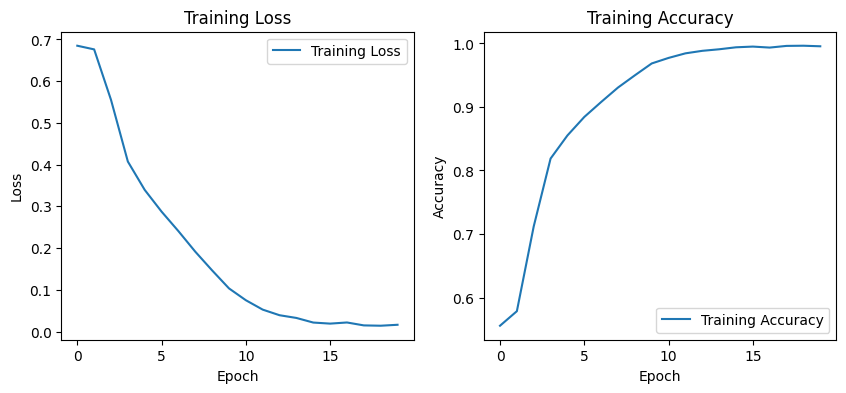

In [29]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout
plt.savefig('training_metrics.png')
plt.show()

# Evaluation on Test Set

In [30]:
def evaluate_model(model, test_loader):
  model.eval()
  correct, total = 0, 0
  with torch.no_grad():
    for text, labels in test_loader:
      text, labels = text.to(device), labels.to(device)
      predictions = model(text).squeeze(1)
      predicted_labels = (predictions > 0.5).float()
      correct += (predicted_labels == labels).sum().item()
      total += labels.size(0)
  accuracy = correct / total

  print(f"Test Accuracy: {accuracy:.4f}")
  return accuracy

# Evaluate
test_accuracy = evaluate_model(model, test_loader)


Test Accuracy: 0.7830
